# **Capstone Project: LaneGuard - AI Lane-Switching Violation Detection System**
**Project Overview**

**LaneGuard** is an AI-powered system designed to prevent lane-switching violations, particularly during traffic congestion. Using traffic camera video, LaneGuard detects and tracks vehicles, monitors their lane changes, and flags violations when lane changes occur during heavy traffic, contributing to smoother traffic flow and reduced congestion. The system leverages computer vision techniques for vehicle detection, tracking, and violation detection to ensure traffic discipline on highways.



## Project Structure:


* Introduction & Project Overview

* Environment Setup

* Exploratory Data Analysis(EDA)

* Model Training {YOLOv8 - Vehicle Detection}

* Model Evaluation

* Model Prediction {Predicting on New Test Images}

* Video Processing {Performing Object Detection on a Video}

* Lane Detection {ROI Visualization on a Single Frame}

* ROI Annotation on Video Frames

* Vehicle Tracking and Counting

* Lane-Switching Violation Detection

* Lane-Switching Violation Detection with Traffic Density Rule

* Conclusion

# 1. Environment Setup

- Checking GPU Status with NVIDIA-SMI
- Installing YOLOv8 and other necessary libraries (ultralytics, OpenCV)

In [ ]:
!nvidia-smi

Sat Sep 28 15:55:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Installing Required Libraries:

This command installs the necessary libraries:

* Roboflow for handling datasets.
* Ultralytics for working with YOLOv8.
* Pillow for image manipulation.

In [2]:
%pip install roboflow ultralytics Pillow

  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)
Using cached filetype-1.2.0-py2.py3-none-any.whl (19 kB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
Note: you may need to restart the kernel to use updated packages.


## Connecting to Roboflow and Downloading Dataset:

In [3]:
%pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="B9aDbn6nslo4mgHYjJRi")
project = rf.workspace("maramworkspace").project("lane_guard-kbfza")
version = project.version(2)
dataset = version.download("yolov8")

Note: you may need to restart the kernel to use updated packages.
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.103, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Lane_Guard--2 in yolov8:: 100%|██████████| 5540/5540 [00:00<00:00, 9384.05it/s]


## Importing Libraries:

In [ ]:
import os
import cv2
import csv
import glob
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from datetime import datetime, timedelta

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


These are the libraries that we will use and help us in managing file paths (os, glob), handling images (cv2), deep learning (YOLO).

#2. Exploratory Data Analysis (EDA)


Explore our dataset by visualizing some images and examining the distribution.

In [ ]:
train_dataset_path= '/content/Lane_Guard--2/train/images'
test_dataset_path='/content/Lane_Guard--2/test/images'
valid_dataset_path='/content/Lane_Guard--2/valid/images'

#### Function to load and display images

In [ ]:
def display_images(dataset_path, title):
    fig, axs = plt.subplots(1, 6, figsize=(20, 4))
    fig.suptitle(title, fontsize=17)

    for i, filename in enumerate(os.listdir(dataset_path)[:6]):
        image_path = os.path.join(dataset_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axs[i].imshow(image)
        axs[i].axis('off')

    plt.show()

In [ ]:
# Display 5 images from each dataset
display_images(train_dataset_path, "Sample of Training Images")
display_images(valid_dataset_path, "Sample of Validation Images")
display_images(test_dataset_path, "Sample of Testing Images")

Output hidden; open in https://colab.research.google.com to view.

## Plot Distribution of Images in Train, Validation, and Test Sets

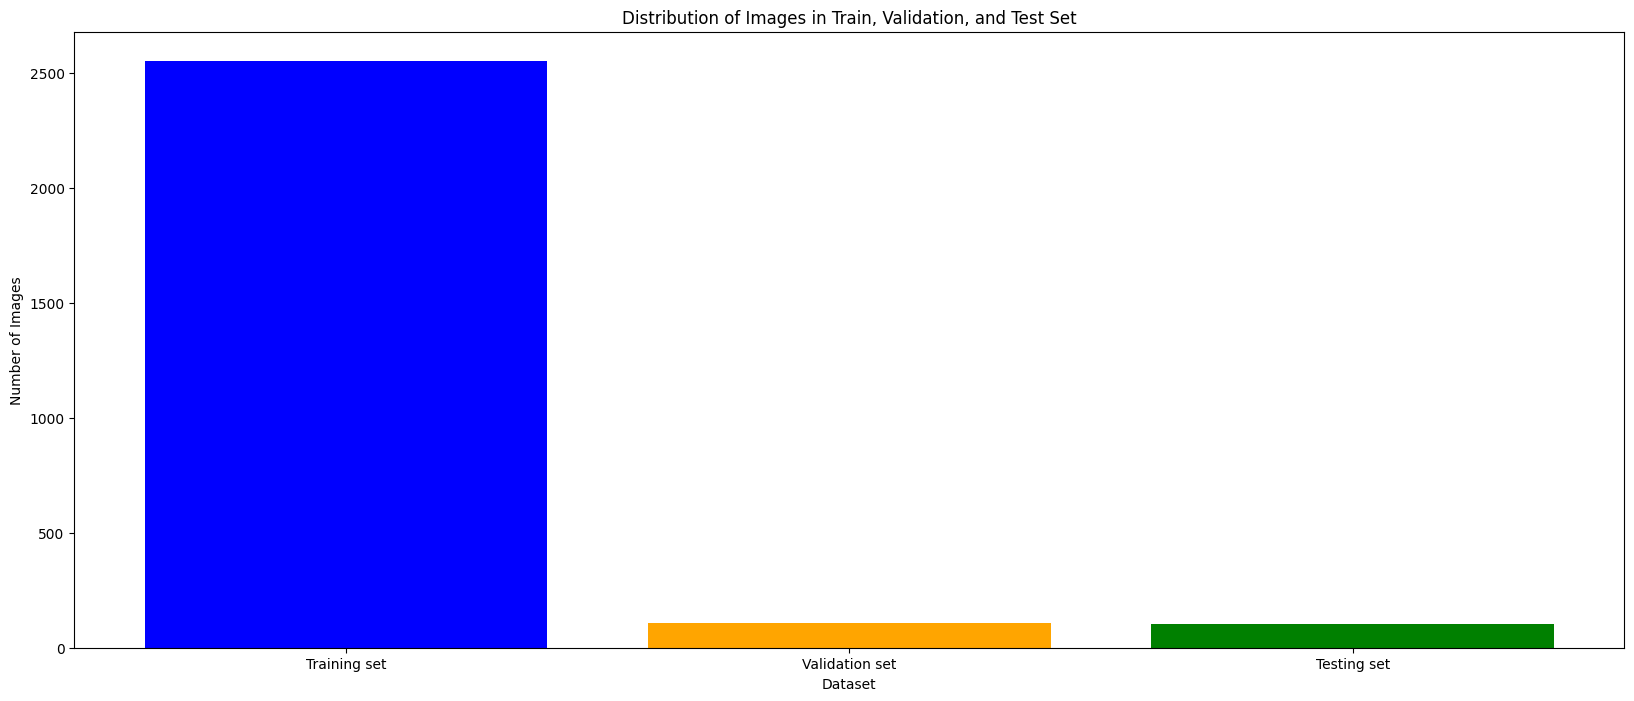

In [ ]:
train_images_count = len(os.listdir(train_dataset_path)) # Count the number of images in each dataset folder (train, valid, test)
valid_images_count = len(os.listdir(valid_dataset_path))
test_images_count = len(os.listdir(test_dataset_path))

counts = [train_images_count, valid_images_count, test_images_count] # Plot the distribution
labels = ['Training set', 'Validation set', 'Testing set']

plt.figure(figsize=(20, 8))
plt.bar(labels, counts, color=['blue', 'orange', 'green'])
plt.title("Distribution of Images in Train, Validation, and Test Set")
plt.xlabel("Dataset")
plt.ylabel("Number of Images")
plt.show()

# Step3: Model Training {YOLOv8 - Vehicle Detection}

In this step, we initiate the training of the YOLOv8 model for the vehicle detection task using the dataset and specific training configurations. The objective is to fine-tune the YOLOv8 model to accurately detect vehicles in various environmental conditions.

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt \
    data=/content/Lane_Guard--2/data.yaml \
    epochs=20 fliplr=0.5 mixup=0.5 shear=0.1 batch=64 seed=0 \
    project='/content/drive/MyDrive/Colab Notebooks/SDAIA-T5-Bootcamp/capstone_project' \
    name='BestModel_For_VehicleDetection'

#Step4: Model Evaluation

in this section we will displays the confusion matrix, overall training results, and the PR_curve from our trained YOLOv8 model for vehicle detection.

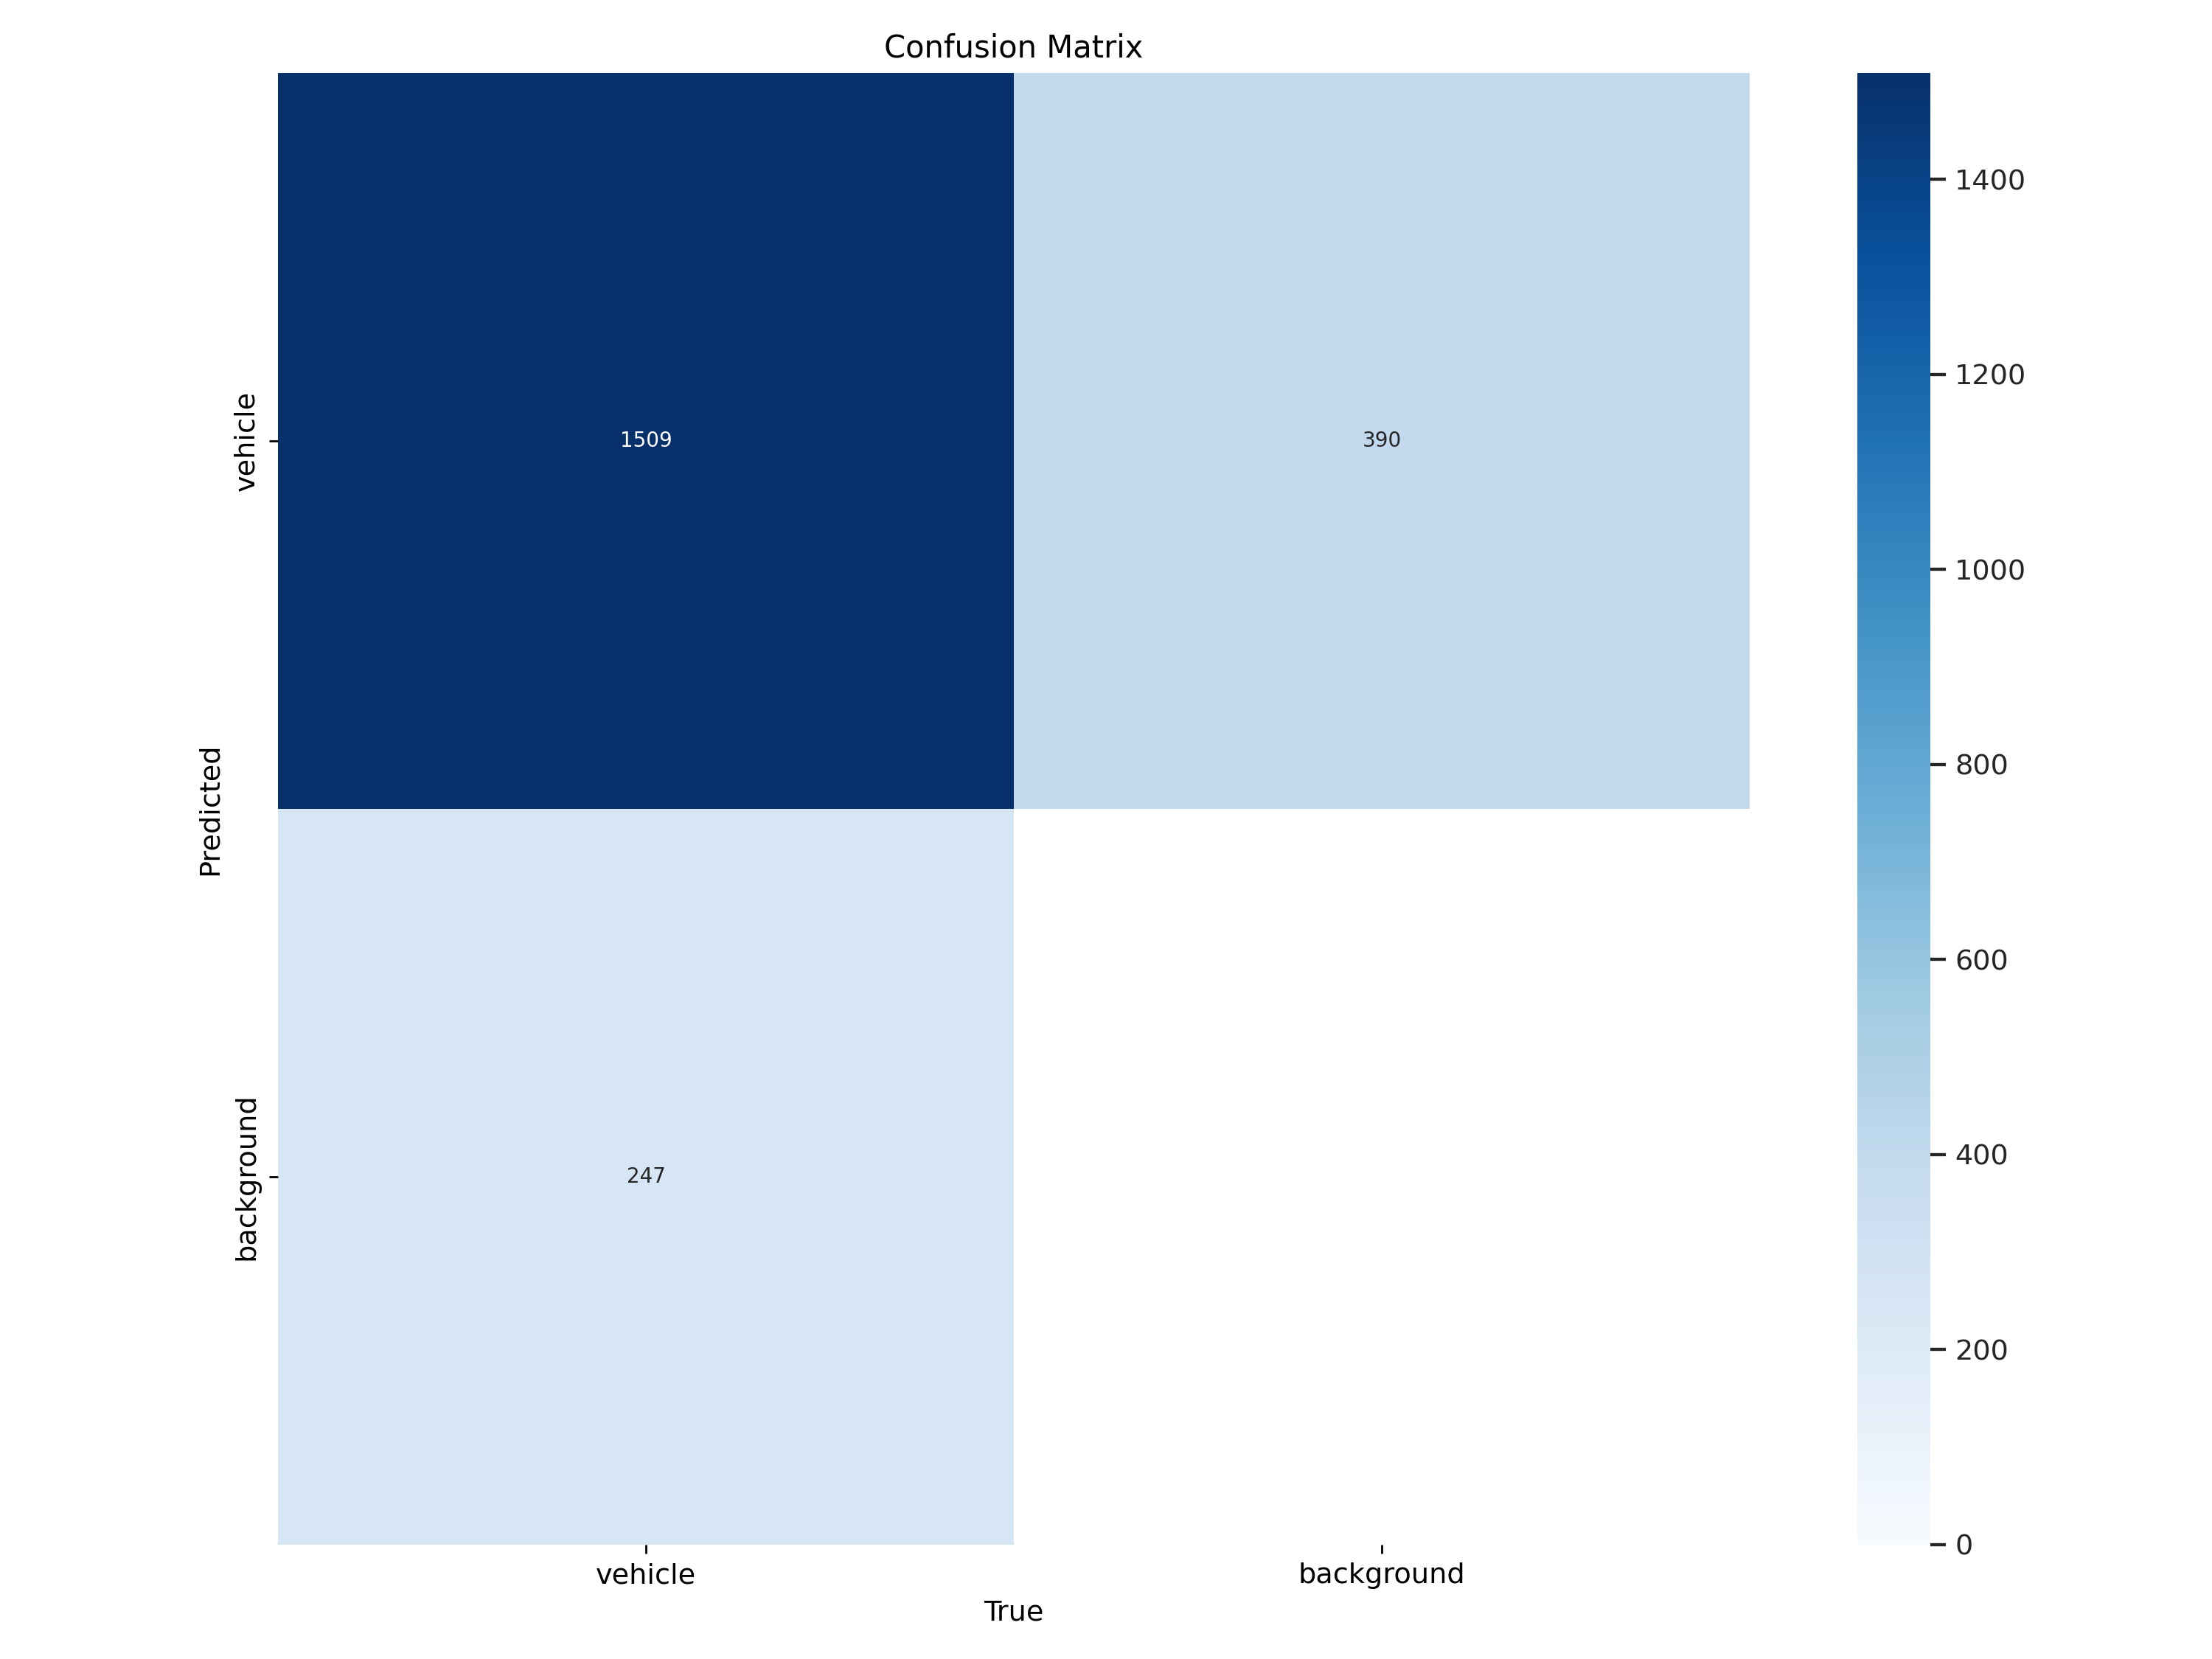

In [ ]:
image_path ='/content/drive/MyDrive/Colab Notebooks/SDAIA-T5-Bootcamp/capstone_project/BestModel_For_VehicleDetection2/confusion_matrix.png'
display(Image(filename=image_path, width=800, height=600))

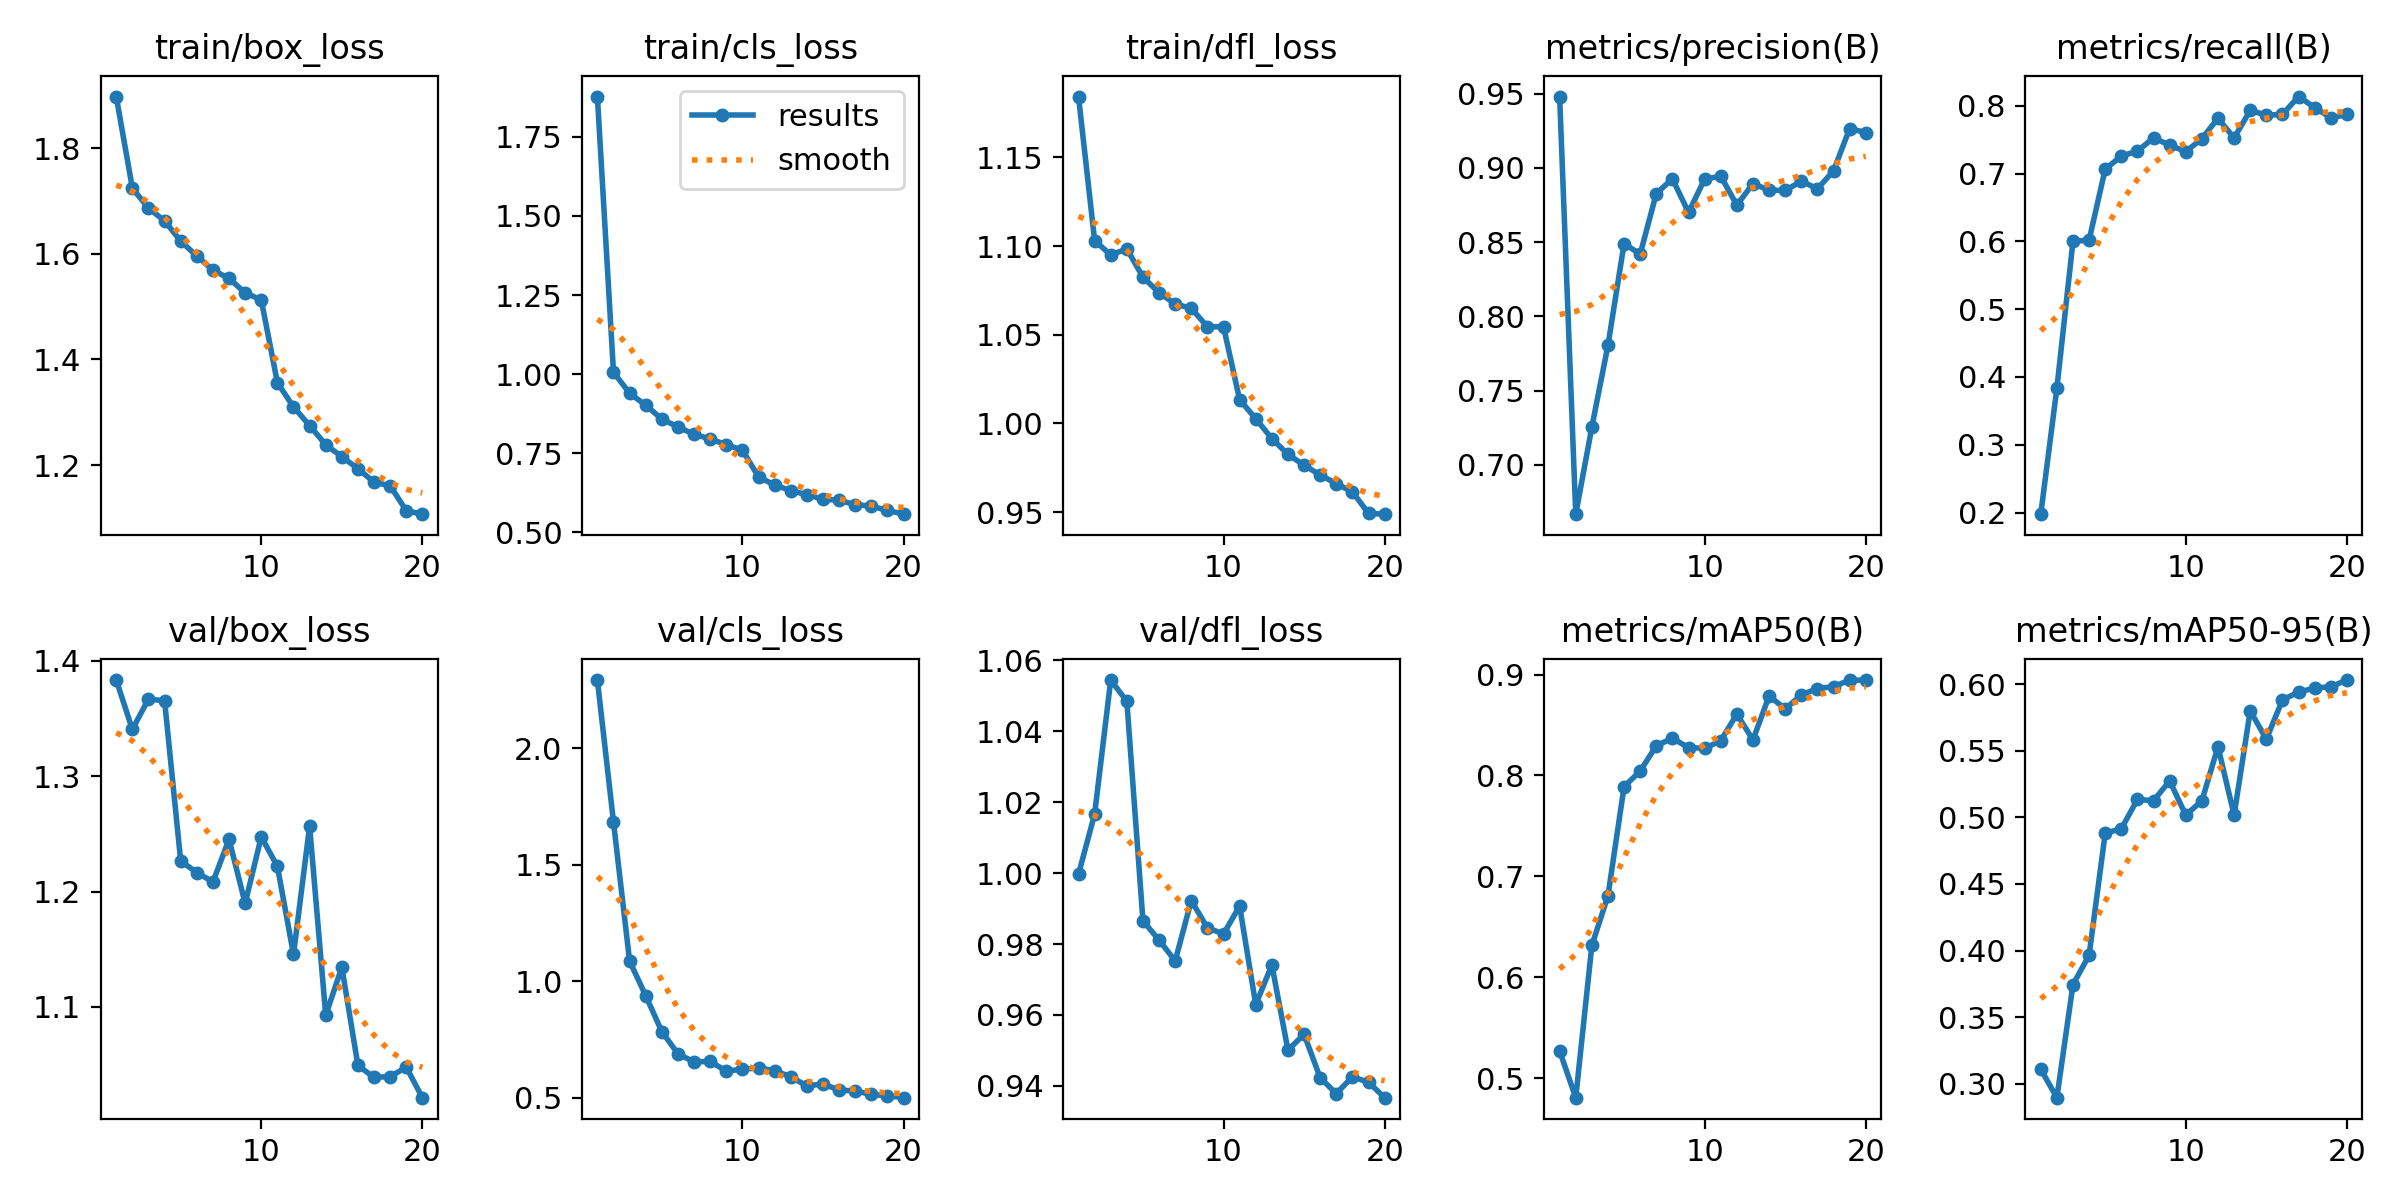

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/SDAIA-T5-Bootcamp/capstone_project/BestModel_For_VehicleDetection2/results.png'
display(Image(filename=image_path, width=1200, height=600))

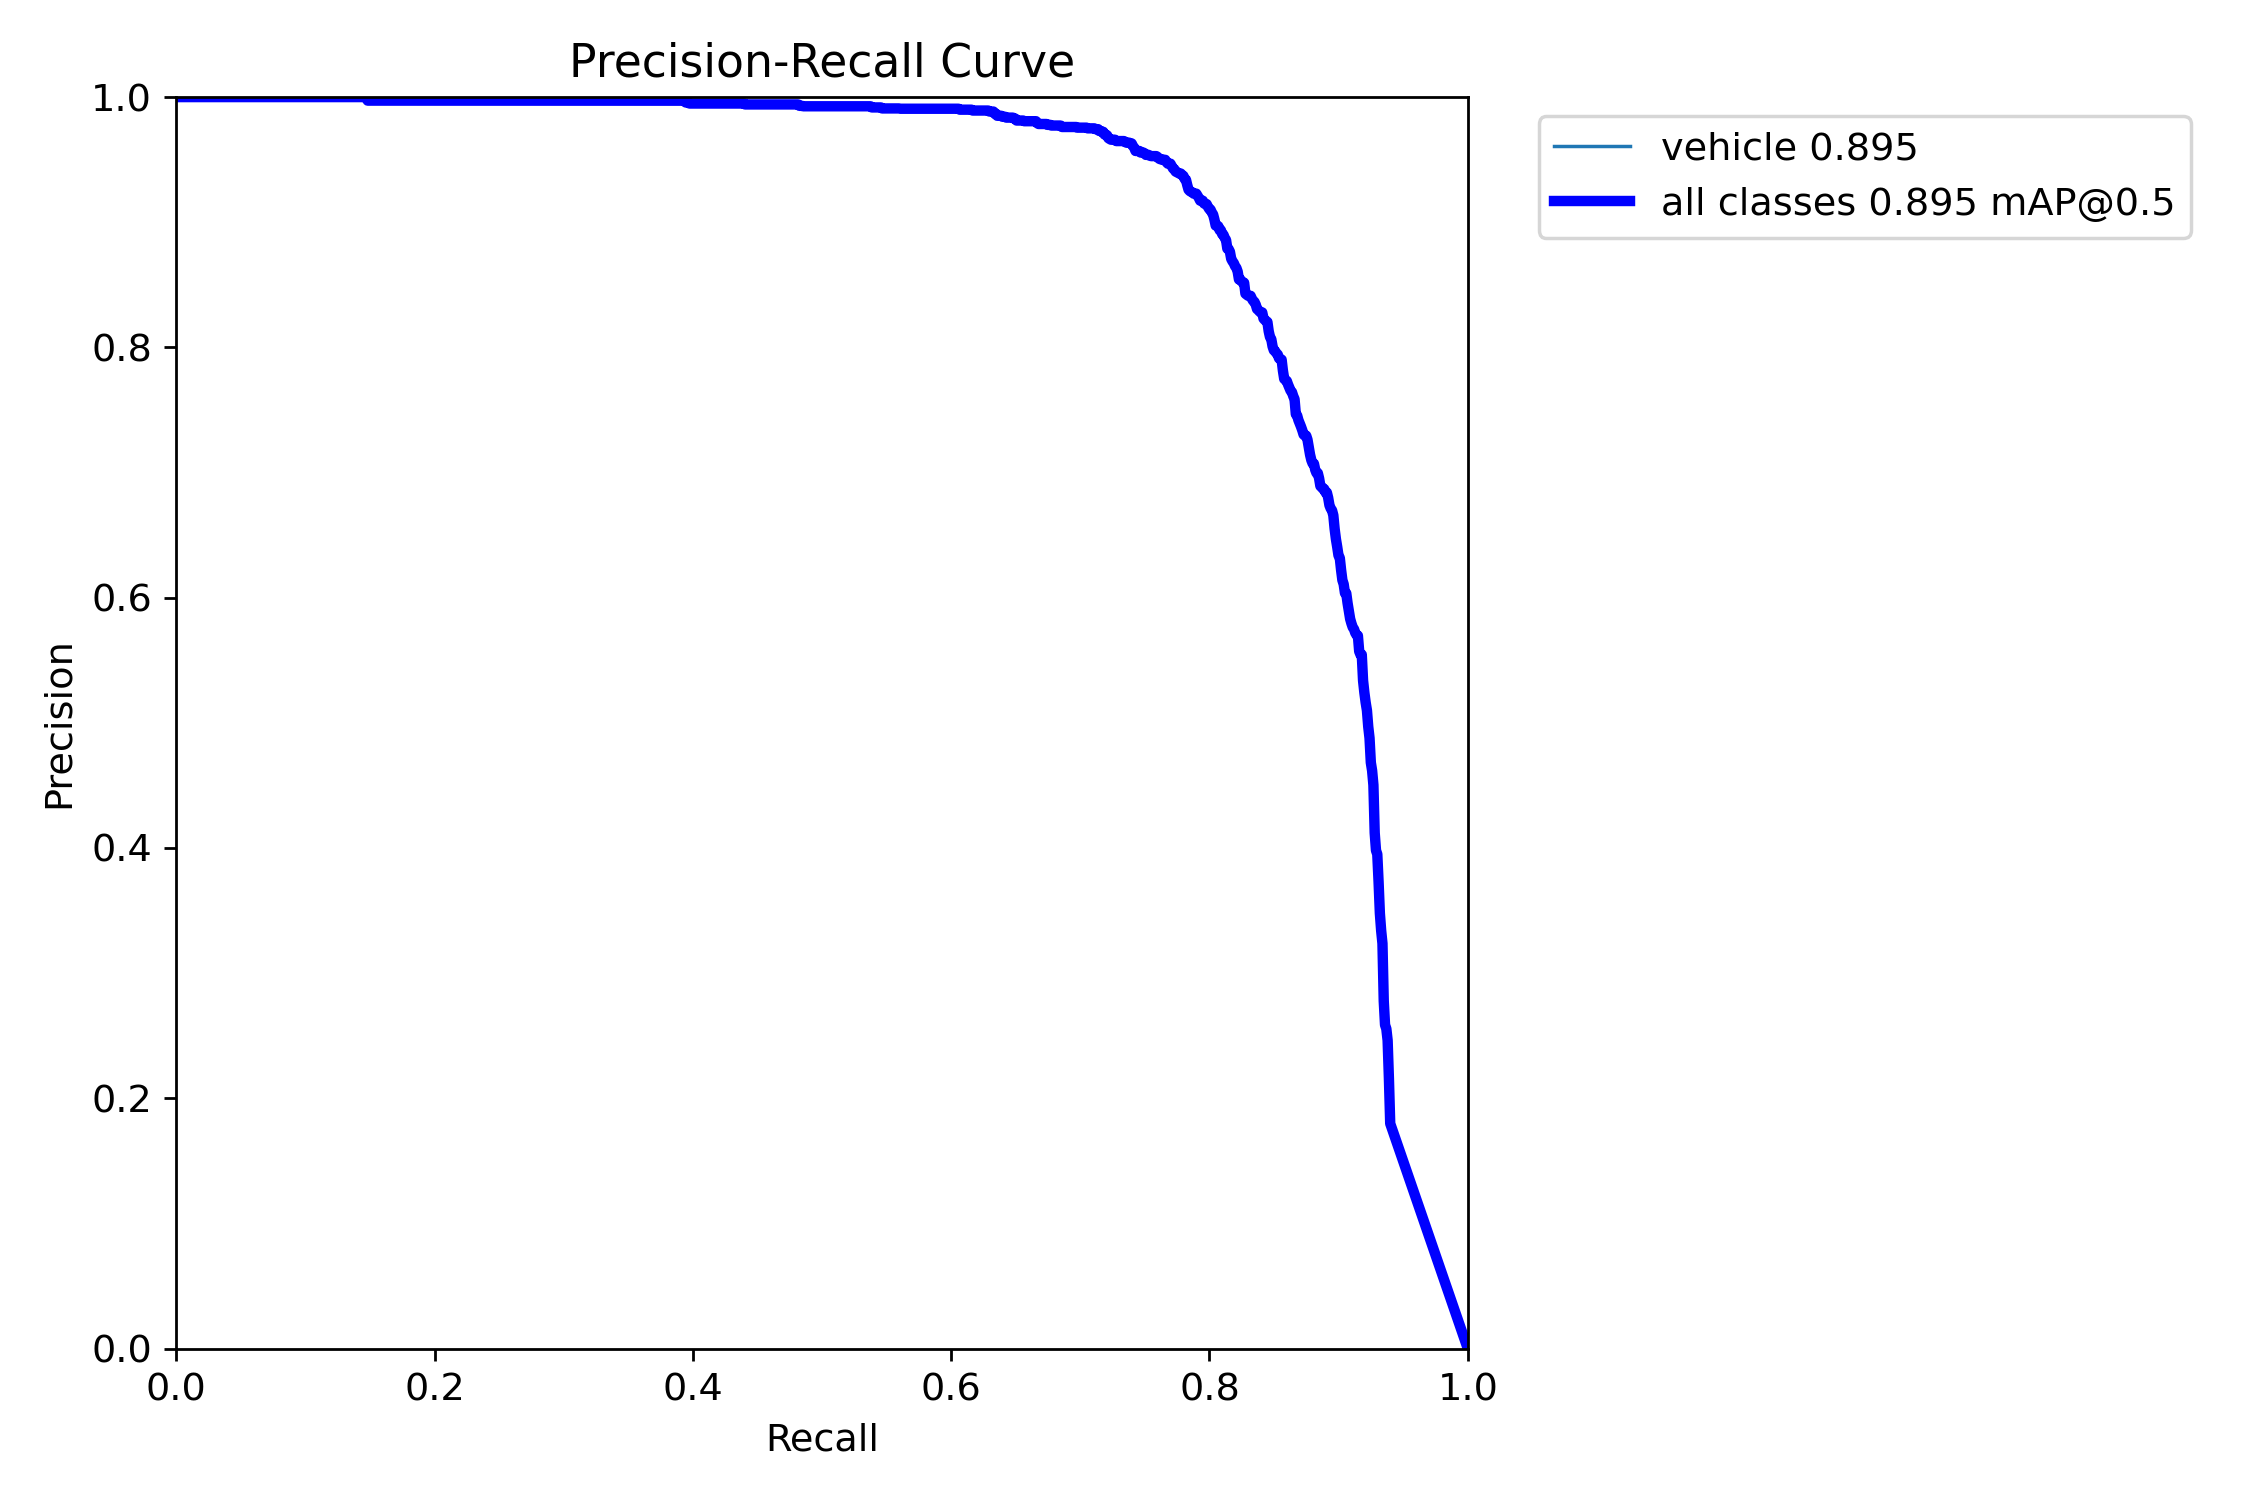

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/SDAIA-T5-Bootcamp/capstone_project/BestModel_For_VehicleDetection2/PR_curve.png'
display(Image(filename=image_path, width=800, height=600))

## Evaluating the Model on the Validation Set
in this step  we will runs the trained YOLOv8 model on the validation dataset. It helps in evaluating the model's performance on unseen data (validation set), and the evaluation metrics like precision, recall, and mAP will be displayed.

In [ ]:
!yolo task=detect mode=val \
    model=/content/drive/MyDrive/Colab\ Notebooks/SDAIA-T5-Bootcamp/capstone_project/BestModel_For_VehicleDetection2/weights/best.pt\
    data=/content/Lane_Guard--2/data.yaml

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
100% 755k/755k [00:00<00:00, 41.8MB/s]
val: Scanning /content/Lane_Guard--2/valid/labels... 106 images, 0 backgrounds, 0 corrupt: 100% 106/106 [00:00<00:00, 977.36it/s]
val: New cache created: /content/Lane_Guard--2/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 7/7 [00:07<00:00,  1.03s/it]
                   all        106       1756      0.919      0.791      0.895      0.606
Speed: 2.1ms preprocess, 4.9ms inference, 0.0ms loss, 38.7ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


#Step5: Model Prediction {Predicting on New Test Images}
Here, the trained YOLOv8 model is used to detect vehicles in new test images. The model predictions will be saved and displayed for visual inspection.

In [ ]:
!yolo task=detect mode=predict \
    model=/content/drive/MyDrive/Colab\ Notebooks/SDAIA-T5-Bootcamp/capstone_project/BestModel_For_VehicleDetection2/weights/best.pt \
    source=/content/Lane_Guard--2/test/images

## Displaying Random Test Images with Predictions
After the predictions are generated, this step randomly selects and displays 5 images with bounding boxes to verify how well the model performs.

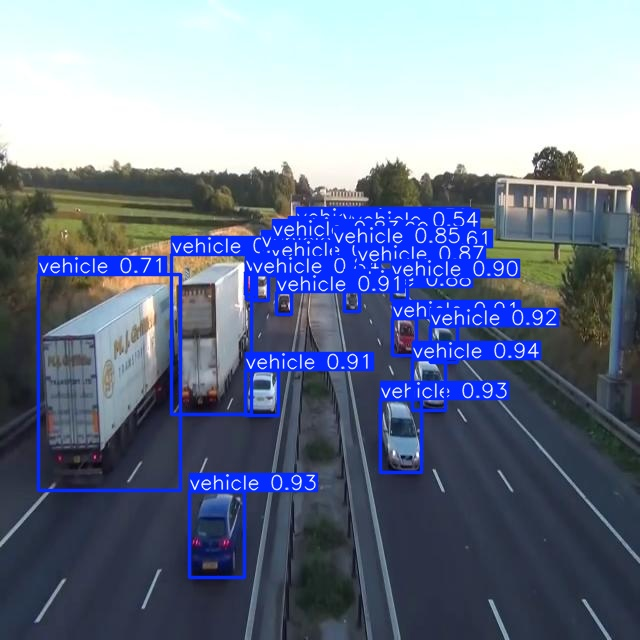

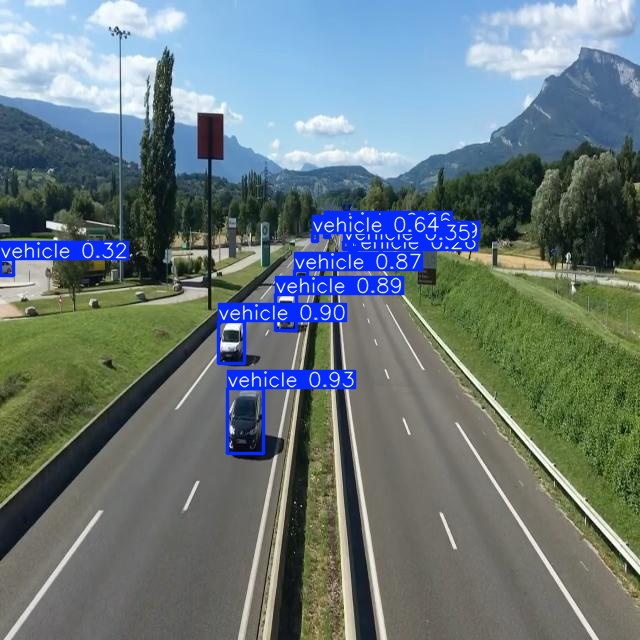

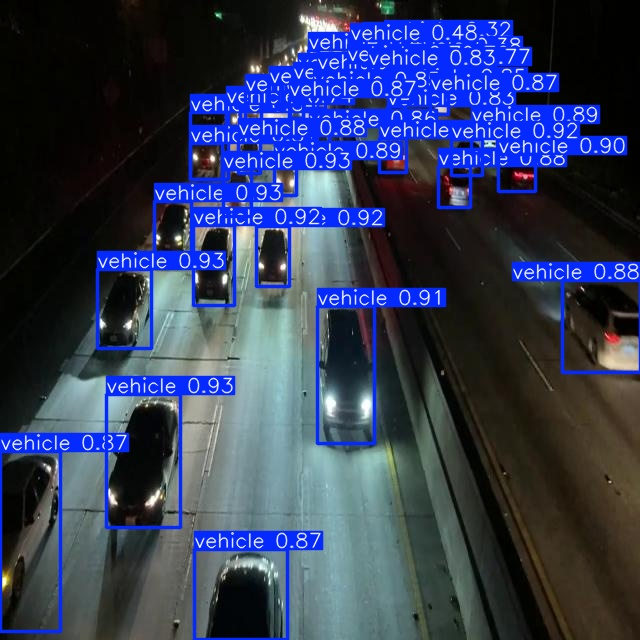

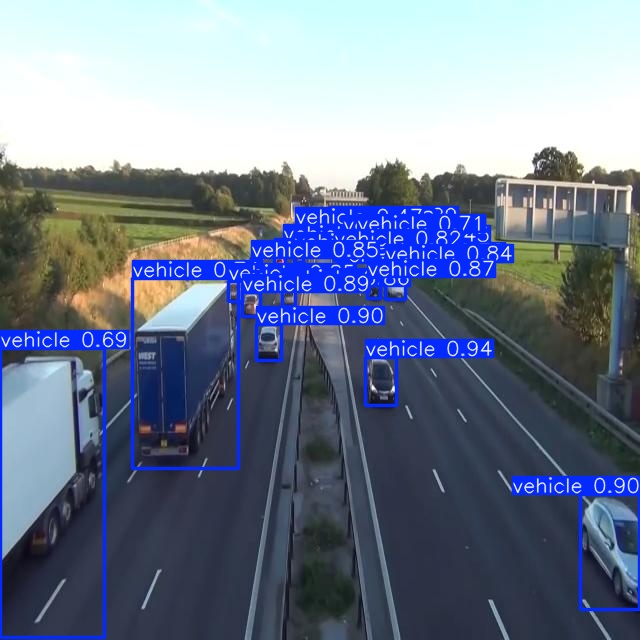

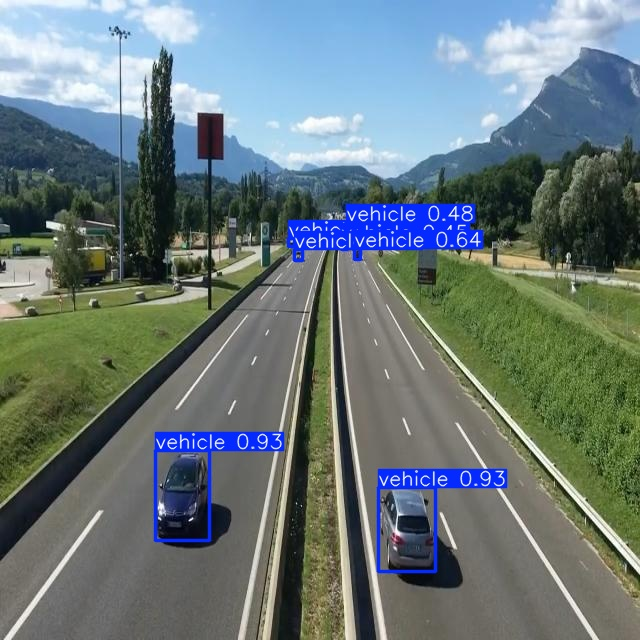

In [ ]:
images_path = glob.glob('/content/runs/detect/predict/*.jpg')

random_images = random.sample(images_path, 5) # Randomly select 5 images

for image in random_images:
    display(Image(filename=image, height=600)) # Display the randomly selected images
    print("\n")

# Step6: Video Processing {Performing Object Detection on a Video}
Here, the YOLOv8 model is used to perform object detection on a video. Each frame of the video is processed, and bounding boxes are drawn for detected vehicles.

* Load the trained YOLOv8 model

In [ ]:
model = YOLO('/content/drive/MyDrive/Colab Notebooks/SDAIA-T5-Bootcamp/capstone_project/BestModel_For_VehicleDetection2/weights/best.pt')

In [ ]:
video_path = '/content/drive/MyDrive/Colab Notebooks/SDAIA-T5-Bootcamp/new_test_video_30_مسرعة.mov'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")            # Check if the video opened successfully
    exit()

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # Get video frame {width, height, frame per second} for saving the output video
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

output_path = '/content/Vehicle_Detection.mp4'       # prepare for writing video frames to a file
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()

    if not ret:
        print("Finished processing the video.")
        break

    results = model(frame)                          # applies the object detection model to the current frame.
    annotated_frame = results[0].plot()             # draw bounding boxes and labels on the frame.

    out.write(annotated_frame)                     # writes the annotated frame to the output video file.

cap.release()
out.release()                                      # save the video file

# Step7: Lane detection and ROI Visualization on a Single Frame

drawing a region of interest (ROI) on a single image frame from a video file, marking lanes and a rectangular area for further vehicle tracking and violation detection.

In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/SDAIA-T5-Bootcamp/new_test_video_30_مسرعة.mov')
assert cap.isOpened(), 'Error reading video file'

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

print(f'WIDTH: {frame_width}, HEIGHT: {frame_height}, FPS: {fps}')

WIDTH: 1902, HEIGHT: 986, FPS: 59


## Define draw_lanes_and_roi to use it for further tasks

In [ ]:
roi_rect_top_left = (250, 200)
roi_rect_bottom_right = (1670, 1000)

roi1_line = [(320, 1000), (840, 250)]
roi2_line = [(700, 1000), (939, 250)]
roi3_line = [(1060, 1000), (1035, 250)]
roi4_line = [(1425, 1000), (1125, 250)]

def draw_lanes_and_roi(frame, roi_top_left, roi_bottom_right):

    cv2.line(frame, roi1_line[0], roi1_line[1], color=(255, 255, 255), thickness=3)
    cv2.line(frame, roi2_line[0], roi2_line[1], color=(255, 255, 255), thickness=3)
    cv2.line(frame, roi3_line[0], roi3_line[1], color=(255, 255, 255), thickness=3)
    cv2.line(frame, roi4_line[0], roi4_line[1], color=(255, 255, 255), thickness=3)

    cv2.rectangle(frame, roi_top_left, roi_bottom_right, (128, 128, 128), 3)

    return frame

In [ ]:
ret, frame = cap.read()
if ret:

    frame = draw_lanes_and_roi(frame, roi_rect_top_left, roi_rect_bottom_right)

    cv2_imshow(frame)  # Show the frame with ROI lines and counter

cap.release()

Output hidden; open in https://colab.research.google.com to view.

# Step8: ROI Annotation on Video Frames
processes a video frame-by-frame, draws lane lines and a rectangular Region of Interest (ROI) on each frame, It is intended for visualizing lanes and an ROI for vehicle detection and tracking.

In [ ]:
output_path = '/content/ROI_Annotation_on_Video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = draw_lanes_and_roi(frame, roi_rect_top_left, roi_rect_bottom_right)

    out.write(frame) # Write the frame to the output video file


cap.release()
out.release()

# step 9: Vehicle Tracking and Counting
tracks and counts vehicles within a defined Region of Interest (ROI) in each frame using our model. It annotates each detected vehicle with its ID, confidence score, and center point.

In [ ]:
output_path = '/content/Vehicle_Tracking_and_Counting.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

current_vehicles = {}  # Dictionary to store active vehicles in the ROI rectangle(by track_id)
vehicle_count = 0      # Total count of cars currently inside the ROI rectangle

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break


    results = model.track(frame, persist=True, show=False) # Detect and track cars using pretrained YOLOv8 model
    tracks = results[0].boxes                              # Get the tracked objects

    new_vehicles = {}                                      # Keep track of cars inside the ROI for this frame

    for track in tracks:
        x1, y1, x2, y2 = track.xyxy[0]  # Get the bounding box coordinates
        track_id = int(track.id[0])     # Track ID for each car
        conf = track.conf[0]            # Confidence score
        cls = track.cls[0]              # Class label (vehicle)


        center_x = int((x1 + x2) / 2)  # Calculate the center of the bounding box
        center_y = int((y1 + y2) / 2)

        if (roi_rect_top_left[0] < center_x < roi_rect_bottom_right[0] and
            roi_rect_top_left[1] < center_y < roi_rect_bottom_right[1]): # If the vehicle is inside the ROI, it is counted and annotated


            new_vehicles[track_id] = True                               # If vehicle is inside the ROI, add to new_vehicles dictionary


            if track_id not in current_vehicles:                       # If this is a new vehicle in the ROI, count it
                vehicle_count += 1


            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2) # If this is a new vehicle in the ROI, count it

            cv2.putText(frame, f'Vehicle ID:{track_id} Conf:{conf:.2f}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (36, 255, 12), 2)

            cv2.circle(frame, (center_x, center_y), radius=5, color=(0, 0, 255), thickness=-1) # the center of the Vehicle

    current_vehicles = new_vehicles # Update current_vehicles dictionary to reflect vehicles still inside the ROI

    frame = draw_lanes_and_roi(frame, roi_rect_top_left, roi_rect_bottom_right)

    cv2.putText(frame, f'Current Numbers of Vehicles: {len(current_vehicles)}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    out.write(frame)

cap.release()
out.release()

# Step 10: Lane-Switching Violation Detection

In this step detects lane-switching violations while tracking and counting vehicles inside a specified Region of Interest (ROI) in a video. It uses a our pretrained model to track vehicles and determine if they switch lanes, based on their bounding box centers. If a vehicle changes lanes, it is flagged as a violation, and the corresponding information is displayed on the video.

* The get_lane function determines which lane a vehicle is in by comparing the center of the bounding box to predefined lane coordinates.

In [ ]:
def get_lane(center_x, center_y):
    if center_x < roi1_line[0][0] + (roi1_line[1][0] - roi1_line[0][0]) * (1000 - center_y) / 750:
        return 1  # First lane
    elif center_x < roi2_line[0][0] + (roi2_line[1][0] - roi2_line[0][0]) * (1000 - center_y) / 750:
        return 2  # Second lane
    elif center_x < roi3_line[0][0] + (roi3_line[1][0] - roi3_line[0][0]) * (1000 - center_y) / 750:
        return 3  # Third lane
    elif center_x < roi4_line[0][0] + (roi4_line[1][0] - roi4_line[0][0]) * (1000 - center_y) / 750:
        return 4  # Fourth lane
    else:
        return 5  # Fifth lane (rightmost side, after fourth lane)

In [ ]:
output_path = '/content/Lane-Switching_Violation_and_Counting.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

current_vehicles = {}
vehicle_count = 0
violation_count = 0     # Count for lane-switching violations
vehicle_last_lane = {}  # Dictionary to store the last lane for each vehicle (by track_id)
vehicle_violations = {} # Dictionary to store violation status for each vehicle

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model.track(frame, persist=True, show=False)
    tracks = results[0].boxes

    new_vehicles = {}

    for track in tracks:
        x1, y1, x2, y2 = track.xyxy[0]
        track_id = int(track.id[0])
        conf = track.conf[0]
        cls = track.cls[0]

        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)


        if (roi_rect_top_left[0] < center_x < roi_rect_bottom_right[0] and
            roi_rect_top_left[1] < center_y < roi_rect_bottom_right[1]):

            new_vehicles[track_id] = True

            if track_id not in current_vehicles:
                vehicle_count += 1

            current_lane = get_lane(center_x, center_y)


            if track_id in vehicle_last_lane:                        # If the vehicle has switched lanes based on its center position
                last_lane = vehicle_last_lane[track_id]
                if last_lane != current_lane:                        # Lane change detected
                    if track_id not in vehicle_violations:
                        violation_count += 1                         # Increment violation count
                        vehicle_violations[track_id] = True
                    box_color = (0, 0, 255)                          # Red bounding box for violation
                    violation_text = "VIOLATION"
                else:
                    box_color = (0, 255, 0)                          # Green bounding box for normal vehicle
                    violation_text = ""
            else:
                box_color = (0, 255, 0)                              # Green for new vehicle
                violation_text = ""

            vehicle_last_lane[track_id] = current_lane               # Update the last known lane for this vehicle


            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), box_color, 2)
            cv2.putText(frame, f'Vehicle ID:{track_id} Conf:{conf:.2f}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (36, 255, 12), 2)
            cv2.circle(frame, (center_x, center_y), radius=5, color=(0, 0, 255), thickness=-1)

            if violation_text:                                      # Display violation message if applicable
                cv2.putText(frame, violation_text, (int(x1), int(y2) + 20),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 3)


    current_vehicles = new_vehicles

    frame = draw_lanes_and_roi(frame, roi_rect_top_left, roi_rect_bottom_right)

    cv2.putText(frame, f'Current Numbers of Vehicles: {len(current_vehicles)}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
    cv2.putText(frame, f'Numbers of Violations: {violation_count}', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

    out.write(frame)

cap.release()
out.release()

# Step11:Lane-Switching Violation Detection with Traffic Density Rule

This detects lane-switching violations only when the vehicle count in the Region of Interest (ROI) exceeds 25, simulating rush hour or heavy traffic conditions. It tracks vehicles, detects lane changes, and annotates violations based on the density of traffic. And save the result to csv files for further analysis.

In [ ]:
output_path = '/content/Lane-Switching_Violation_with_Traffic_Density_Rule.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

current_vehicles = {}
vehicle_count = 0
violation_count = 0
vehicle_last_lane = {}
vehicle_violations = {}

csv_filename = 'traffic_data.csv' # Initialize CSV file
csv_headers = ['Timestamp', 'Current_Vehicles_in_ROI', 'Violation_Count', 'Violation_Percentage','Street_Name', 'Latitude', 'Longitude', 'Hour_of_Day', 'Day_of_Week']

with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.DictWriter(csvfile, fieldnames=csv_headers)
    csv_writer.writeheader()

start_time = datetime(2023, 1, 1, 8, 0, 0)  # Example: January 1, 2023, 8:00 AM
frame_count = 0

street_name = "Golden Sand Street" # Simulated location data
latitude = 24.7136
longitude = 46.6753

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model.track(frame, persist=True, show=False)
    tracks = results[0].boxes

    new_vehicles = {}

    for track in tracks:
        x1, y1, x2, y2 = track.xyxy[0]
        track_id = int(track.id[0])
        conf = track.conf[0]
        cls = track.cls[0]

        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)

        if (roi_rect_top_left[0] < center_x < roi_rect_bottom_right[0] and
            roi_rect_top_left[1] < center_y < roi_rect_bottom_right[1]):

            new_vehicles[track_id] = True

            if track_id not in current_vehicles:
                vehicle_count += 1

            if len(new_vehicles) >= 25:

                current_lane = get_lane(center_x, center_y)

                if track_id in vehicle_last_lane:
                    last_lane = vehicle_last_lane[track_id]
                    if last_lane != current_lane:
                        if track_id not in vehicle_violations:
                            violation_count += 1
                            vehicle_violations[track_id] = True
                        box_color = (0, 0, 255)
                        violation_text = "VIOLATION"
                    else:
                        box_color = (0, 255, 0)
                        violation_text = ""
                else:
                    box_color = (0, 255, 0)
                    violation_text = ""

                vehicle_last_lane[track_id] = current_lane
            else:
                box_color = (0, 255, 0)
                violation_text = ""

            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), box_color, 2)
            cv2.putText(frame, f'ID:{track_id} Conf:{conf:.2f}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (36, 255, 12), 2)
            cv2.circle(frame, (center_x, center_y), radius=5, color=(0, 0, 255), thickness=-1)

            if violation_text:
                cv2.putText(frame, violation_text, (int(x1), int(y2) + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    current_vehicles = new_vehicles

    frame = draw_lanes_and_roi(frame, roi_rect_top_left, roi_rect_bottom_right)

    cv2.putText(frame, f'Current Numbers of Vehicles: {len(current_vehicles)}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
    cv2.putText(frame, f'Numbers of Violations: {violation_count}', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

    out.write(frame)

    current_time = start_time + timedelta(seconds=frame_count/fps)  # Calculate current timestamp
    frame_count += 1

    # Calculate violation percentage
    violation_percentage = (violation_count / len(current_vehicles) * 100) if len(current_vehicles) > 0 else 0

    csv_data = {
        'Timestamp': current_time.strftime('%Y-%m-%d %H:%M:%S'),
        'Current_Vehicles_in_ROI': len(current_vehicles),
        'Violation_Count': violation_count,
        'Violation_Percentage': round(violation_percentage, 2),
        'Street_Name': street_name,
        'Latitude': latitude,
        'Longitude': longitude,
        'Hour_of_Day': current_time.hour,
        'Day_of_Week': current_time.strftime('%A')
    }

    with open(csv_filename, 'a', newline='') as csvfile:
        csv_writer = csv.DictWriter(csvfile, fieldnames=csv_headers)
        csv_writer.writerow(csv_data)


cap.release()
out.release()

# Conclusion

This project developed a lane-switching violation detection system using YOLOv8 to monitor vehicle lane changes during heavy traffic. Violations are flagged based on traffic density. The system offers a valuable tool for reducing congestion and improving traffic flow.